# 1. 실험환경 구성 (Experimental setting)

In [3]:
# 라이브러리 로드

import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from IPython.display import Image

print("라이브러리 사용준비 완료")

라이브러리 사용준비 완료


# 2. 데이터 불러오기 (Data loading)

In [4]:
## github에서 데이터 읽어오기 (CSV 파일 읽기)
df = pd.read_csv('https://gist.githubusercontent.com/Harsh-Git-Hub/2979ec48043928ad9033d8469928e751/raw/72de943e040b8bd0d087624b154d41b2ba9d9b60/retail_dataset.csv', sep=',')

## 로컬에 CSV 파일 다운받고 읽어오기 (option)
#df = pd.read_csv('./data/retail_data.csv', sep=',') 

## 데이터 5줄만 일부 찍기
df.head(5)

,0,1,2,3,4,5,6
0,Bread,Wine,Eggs,Meat,Cheese,Pencil,Diaper
1,Bread,Cheese,Meat,Diaper,Wine,Milk,Pencil
2,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
3,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
4,Meat,Pencil,Wine,NaN,NaN,NaN,NaN


In [5]:
# Data 형태, 구조 찍기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       315 non-null    object
 1   1       285 non-null    object
 2   2       245 non-null    object
 3   3       187 non-null    object
 4   4       133 non-null    object
 5   5       71 non-null     object
 6   6       41 non-null     object
dtypes: object(7)
memory usage: 17.4+ KB


<b>Comments.</b> DataFrame은 Python에서 pandas 라이브러리를 통해 가장 자주 데이터 객체 타입입니다. 사용법을 알아두시면, DB에서 데이터를 불러오거나, WEB 상에서 json으로 파일을 받는 경우에도 쉽게 사용이 가능합니다.

<b>Comments.</b> df.info() 명령어를 통해 dataframe 객체에 대해 몇개의 샘플(entry)가 있는지, 칼럼(columns) 수는 몇개인지, 그리고 해당 data object의 사용 메모리량은 얼마인지 조회 가능합니다.

# 3. 전처리 (Data Preprocessing)

- 필드마다 NaN이 가장 많음. 
- 왜 문제? 조회 시, NaN이 가장 많다고 나오게 됨.
- 5,6번째 변수에 NaN 의미. <- 이 장바구니 분석에서는 최대 6개 이하 아이템 장바구니까지만 존재함.

In [6]:
df.head(15)

,0,1,2,3,4,5,6
0,Bread,Wine,Eggs,Meat,Cheese,Pencil,Diaper
1,Bread,Cheese,Meat,Diaper,Wine,Milk,Pencil
2,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
3,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
4,Meat,Pencil,Wine,NaN,NaN,NaN,NaN
5,Eggs,Bread,Wine,Pencil,Milk,Diaper,Bagel
6,Wine,Pencil,Eggs,Cheese,NaN,NaN,NaN
7,Bagel,Bread,Milk,Pencil,Diaper,NaN,NaN
8,Bread,Diaper,Cheese,Milk,Wine,Eggs,NaN
9,Bagel,Wine,Diaper,Meat,Pencil,Eggs,Cheese


0부터 5까지의 6개 변수 중 unique한 값 조회

In [7]:
# data에 어떠한 항목들이 있는지 알아보자.
# (칼럼 별) 변수값들 중 unique한 값 가져오기

for i in range(0,6):
    items = df[str(i)].unique()
    print("[",i,"]:", items)

[ 0 ]: ['Bread' 'Cheese' 'Meat' 'Eggs' 'Wine' 'Bagel' 'Pencil' 'Diaper' 'Milk']
[ 1 ]: ['Wine' 'Cheese' 'Meat' 'Pencil' 'Bread' 'Diaper' 'Eggs' nan 'Bagel'
 'Milk']
[ 2 ]: ['Eggs' 'Meat' 'Wine' 'Milk' 'Cheese' 'Diaper' 'Pencil' nan 'Bagel'
 'Bread']
[ 3 ]: ['Meat' 'Diaper' 'Milk' nan 'Pencil' 'Cheese' 'Bread' 'Bagel' 'Wine'
 'Eggs']
[ 4 ]: ['Cheese' 'Wine' nan 'Milk' 'Diaper' 'Pencil' 'Meat' 'Bagel' 'Bread'
 'Eggs']
[ 5 ]: ['Pencil' 'Milk' nan 'Diaper' 'Eggs' 'Wine' 'Cheese' 'Bagel' 'Meat'
 'Bread']


NaN 필드 처리

In [8]:
items = (df['0'].unique())
items

array(['Bread', 'Cheese', 'Meat', 'Eggs', 'Wine', 'Bagel', 'Pencil',
       'Diaper', 'Milk'], dtype=object)

One hot encoding, 함수 정의 및 실행

In [9]:
encoded_vals = []

# 함수 기능: 특정 항목이 있으면, '1' 아니면 '0'으로 one hot encoding
# 변경 전: ['Bread' 'Cheese' 'Meat' 'Eggs' 'Wine' 'Bagel' 'Pencil' 'Diaper' 'Milk']]
# 변경 후: [0,0,1,1,1,1,0,1,...]

def custom_one_hot_encoding(df):
    for index, row in df.iterrows():
        labels = {}
        
        total_item = set(items) # 전체 아이템 목록
        # 예시. {'Milk', 'Cheese', 'Wine', 'Eggs', 'Diaper', 'Bagel', 'Bread', 'Pencil', 'Meat'}
        
        selected_item = set(row) # 해당 transaction(row)에 없는 항목
        # 예시. {'Cheese', 'Wine', 'Eggs', 'Diaper', 'Bread', 'Pencil', 'Meat'}
        
        uncommons = list(total_item - selected_item) # 없는 항목
        # 예시. ['Milk', 'Bagel']
        commons = list(total_item.intersection(row))

        # Uncommons인 경우 0, Commons인 경우 1로 인코딩
        for uc in uncommons:
            labels[uc] = 0
        for com in commons:
            labels[com] = 1
        encoded_vals.append(labels)
    encoded_vals[0]
    ohe_df = pd.DataFrame(encoded_vals)

    # Dataframe 객체 반환
    return ohe_df

# encoding 수행
ohe_df = custom_one_hot_encoding(df)

<b>Comments.</b> 위와 같이 함수를 정의할 수도 있고, mlxtend의 Encoder 구현체를 사용해도 좋습니다.

In [10]:
ohe_df.head(10)

,Milk,Bagel,Cheese,Diaper,Pencil,Meat,Bread,Eggs,Wine
0,0,0,1,1,1,1,1,1,1
1,1,0,1,1,1,1,1,0,1
2,1,0,1,0,0,1,0,1,1
3,1,0,1,0,0,1,0,1,1
4,0,0,0,0,1,1,0,0,1
5,1,1,0,1,1,0,1,1,1
6,0,0,1,0,1,0,0,1,1
7,1,1,0,1,1,0,1,0,0
8,1,0,1,1,0,0,1,1,1
9,0,1,1,1,1,1,0,1,1


<b>Comments.</b> 위의 표와 같이 각 샘플(entry)마다 특정 상품을 구매했는지 여부를, one hot encoding 한 matrix로 변경했습니다.

<br/>


## ※ 실험을 시작하기 전, 연관규칙분석의 측정 지표 3가지를 리뷰합시다.

<img src="https://www.saedsayad.com//images//AR_1.png" width="350" align="left"><br/>

# 4. A priori algorithm 적용 (Applying Apriori)

- 이 중에서 A priori algorithm은 지지도에 기반하여 빈출하는 아이템 또는 아이템셋(itemset)을 가려냅니다.
- 이 때, A priori algorithm은 '최소 지지도' 하이퍼파라미터 설정이 필요합니다.
    - 예시. 최소 지지도가 0.3 이라면, 전체 관측치(장바구니) 10개 중에 3번 이상 등장한 아이템 또는 아이템셋을 찾게 됩니다.
- 최소 지지도를 아래와 같이 0.3 -> 0.5 -> 0.7 로 변경하면서 몇 개의 규칙(Rule)이 도출되는지 실험해봅니다.

In [11]:
# min_sup: 최소 지지도 (Min. Support)

for i, min_sup in enumerate([0.3, 0.5, 0.7]):
    freq_items = apriori(ohe_df, min_support=min_sup, use_colnames=True, max_len=None, verbose=0, low_memory=False)
    print(freq_items)
    print("\n")

     support        itemsets
0   0.501587          (Milk)
1   0.425397         (Bagel)
2   0.501587        (Cheese)
3   0.406349        (Diaper)
4   0.361905        (Pencil)
5   0.476190          (Meat)
6   0.504762         (Bread)
7   0.438095          (Eggs)
8   0.438095          (Wine)
9   0.304762  (Milk, Cheese)
10  0.323810  (Cheese, Meat)


    support  itemsets
0  0.501587    (Milk)
1  0.501587  (Cheese)
2  0.504762   (Bread)


Empty DataFrame
Columns: [support, itemsets]
Index: []




최소 지지도를 0.2로 설정하고 실험을 진행합시다.

In [12]:
freq_items = apriori(ohe_df, min_support=0.15, use_colnames=True, max_len=None, verbose=0, low_memory=False)

print("규칙 수: ", len(freq_items),"\n")
print(freq_items)

규칙 수:  54 

     support                    itemsets
0   0.501587                      (Milk)
1   0.425397                     (Bagel)
2   0.501587                    (Cheese)
3   0.406349                    (Diaper)
4   0.361905                    (Pencil)
5   0.476190                      (Meat)
6   0.504762                     (Bread)
7   0.438095                      (Eggs)
8   0.438095                      (Wine)
9   0.225397               (Milk, Bagel)
10  0.304762              (Milk, Cheese)
11  0.155556              (Diaper, Milk)
12  0.171429              (Milk, Pencil)
13  0.244444                (Milk, Meat)
14  0.279365               (Milk, Bread)
15  0.244444                (Milk, Eggs)
16  0.219048                (Milk, Wine)
17  0.193651             (Bagel, Cheese)
18  0.184127             (Diaper, Bagel)
19  0.158730             (Bagel, Pencil)
20  0.190476               (Bagel, Meat)
21  0.279365              (Bread, Bagel)
22  0.152381               (Bagel, Eggs)
23  

- A priori algorithm으로 탐색 결과, 최소 지지도 0.2 이상의 33개 규칙을 선정했습니다.
- 33개의 규칙을 기준으로 이후 신뢰도(confidence), 향상도(lift)를 분석합니다.

# 5. 연관규칙분석 (Mining Association Rules)

In [13]:
# mining results

rules = association_rules(freq_items, metric="confidence", min_threshold=0.55)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Milk),(Cheese),0.501587,0.501587,0.304762,0.607595,1.211344,0.053172,1.270148
1,(Cheese),(Milk),0.501587,0.501587,0.304762,0.607595,1.211344,0.053172,1.270148
2,(Milk),(Bread),0.501587,0.504762,0.279365,0.556962,1.103415,0.026183,1.117823
3,(Bread),(Milk),0.504762,0.501587,0.279365,0.553459,1.103415,0.026183,1.116164
4,(Eggs),(Milk),0.438095,0.501587,0.244444,0.557971,1.112411,0.024701,1.127557
5,(Bread),(Bagel),0.504762,0.425397,0.279365,0.553459,1.301042,0.064641,1.286787
6,(Bagel),(Bread),0.425397,0.504762,0.279365,0.656716,1.301042,0.064641,1.442650
7,(Pencil),(Cheese),0.361905,0.501587,0.200000,0.552632,1.101765,0.018473,1.114099
8,(Cheese),(Meat),0.501587,0.476190,0.323810,0.645570,1.355696,0.084958,1.477891
9,(Meat),(Cheese),0.476190,0.501587,0.323810,0.680000,1.355696,0.084958,1.557540


- 위에서도 최소 신뢰도를 0.55으로 설정합니다.
- 최소 지지도를 만족한 33개의 규칙에 대한 선행사건, 후행사건 조합으로 총 29개 규칙이 최소 신뢰도를 만족했습니다.

# 6. 분석결과 가시화 (Visualizing results)

## 6.1. Support vs. Confidence

- 지지도와 신뢰도 간의 관계성을 보고자 산점도를 그려봅니다.

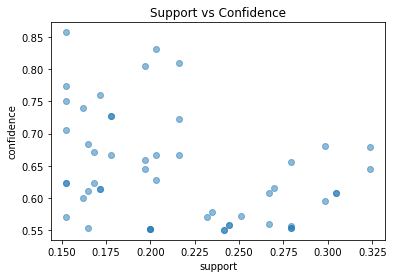

In [14]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.5) # X축, Y축의 값, 그리고 alpha는 색의 투명도
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

- 최소 지지도 0.2와 최소 신뢰도 0.55를 만족하는 규칙들을 plotting 한 결과입니다.

## 6.2. Support vs. Lift

- 여기서는 지지도와 향상도를 비교합니다.
- 최소 향상도를 1.35으로 설정합니다.

In [17]:
rules2 = association_rules(freq_items, metric="lift", min_threshold=1.9)
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Milk, Eggs)","(Cheese, Meat)",0.244444,0.323810,0.152381,0.623377,1.925134,0.073228,1.795402
1,"(Eggs, Cheese)","(Milk, Meat)",0.298413,0.244444,0.152381,0.510638,2.088975,0.079436,1.543961
2,"(Milk, Meat)","(Eggs, Cheese)",0.244444,0.298413,0.152381,0.623377,2.088975,0.079436,1.862835
3,"(Cheese, Meat)","(Milk, Eggs)",0.323810,0.244444,0.152381,0.470588,1.925134,0.073228,1.427160


- 최소 지지도를 만족한 33개의 규칙에 대한 선행사건, 후행사건 조합에서 총 14개 규칙이 최소 향상도 (1.35)를 만족했습니다.
- 테이블 중에 lift 뒤에 leverage, conviction은 연관규칙분석에 부가적인 척도라고 입니다.
  - leverage는 선행사건(X), 후행사건(Y)이 단독, 동시 발생할 모든 확률에서 독립적으로 발생할 확률을 뺀 값입니다.
  - conviction은 Y없이 X가 발생한 비율입니다. 이 값이 높을수록 규칙의 실패율이 높습니다.

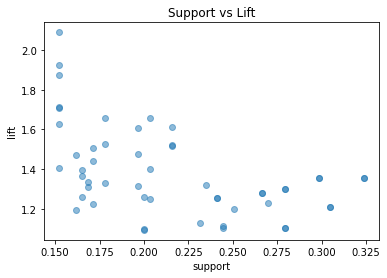

In [18]:
plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

최소 지지도 0.2와 최소 향상도 1.35를 만족하는 규칙들을 plotting 한 것입니다.

## 6.3. Lift vs. Confidence

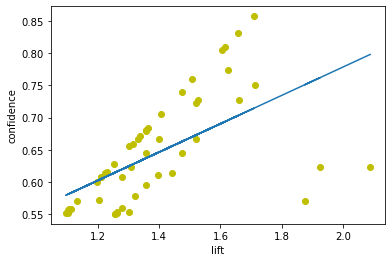

In [19]:
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.xlabel('lift')
plt.ylabel('confidence')
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], fit_fn(rules['lift']))

** Reference site: https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c